In [1]:
!pip install -q torchsummary

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import math
from sklearn.model_selection import train_test_split
from torchsummary import summary
from sklearn.metrics import classification_report
from torch.optim.lr_scheduler import OneCycleLR
import time
import pandas as pd

In [2]:
# KANLinear class definition as provided
class KANLinear(nn.Module):
    def __init__(self, in_features, out_features, grid_size=5, spline_order=3, scale_noise=0.1, scale_base=1.0, scale_spline=1.0, enable_standalone_scale_spline=True, base_activation=nn.SiLU, grid_eps=0.02, grid_range=[-1, 1]):
        super(KANLinear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.grid_size = grid_size
        self.spline_order = spline_order

        h = (grid_range[1] - grid_range[0]) / grid_size
        grid = ((torch.arange(-spline_order, grid_size + spline_order + 1) * h + grid_range[0]).expand(in_features, -1).contiguous())
        self.register_buffer("grid", grid)

        self.base_weight = nn.Parameter(torch.Tensor(out_features, in_features))
        self.spline_weight = nn.Parameter(torch.Tensor(out_features, in_features, grid_size + spline_order))
        if enable_standalone_scale_spline:
            self.spline_scaler = nn.Parameter(torch.Tensor(out_features, in_features))

        self.scale_noise = scale_noise
        self.scale_base = scale_base
        self.scale_spline = scale_spline
        self.enable_standalone_scale_spline = enable_standalone_scale_spline
        self.base_activation = base_activation()
        self.grid_eps = grid_eps

        self.reset_parameters()

    def reset_parameters(self):
        nn.init.kaiming_uniform_(self.base_weight, a=math.sqrt(5) * self.scale_base)
        with torch.no_grad():
            noise = ((torch.rand(self.grid_size + 1, self.in_features, self.out_features) - 1 / 2) * self.scale_noise / self.grid_size)
            self.spline_weight.data.copy_((self.scale_spline if not self.enable_standalone_scale_spline else 1.0) * self.curve2coeff(self.grid.T[self.spline_order : -self.spline_order], noise))
            if self.enable_standalone_scale_spline:
                nn.init.kaiming_uniform_(self.spline_scaler, a=math.sqrt(5) * self.scale_spline)

    def b_splines(self, x: torch.Tensor):
        assert x.dim() == 2 and x.size(1) == self.in_features
        grid = self.grid
        x = x.unsqueeze(-1)
        bases = ((x >= grid[:, :-1]) & (x < grid[:, 1:])).to(x.dtype)
        for k in range(1, self.spline_order + 1):
            bases = ((x - grid[:, : -(k + 1)]) / (grid[:, k:-1] - grid[:, : -(k + 1)]) * bases[:, :, :-1]) + ((grid[:, k + 1 :] - x) / (grid[:, k + 1 :] - grid[:, 1:(-k)]) * bases[:, :, 1:])
        assert bases.size() == (x.size(0), self.in_features, self.grid_size + self.spline_order)
        return bases.contiguous()

    def curve2coeff(self, x: torch.Tensor, y: torch.Tensor):
        assert x.dim() == 2 and x.size(1) == self.in_features
        assert y.size() == (x.size(0), self.in_features, self.out_features)
        A = self.b_splines(x).transpose(0, 1)
        B = y.transpose(0, 1)
        solution = torch.linalg.lstsq(A, B).solution
        result = solution.permute(2, 0, 1)
        assert result.size() == (self.out_features, self.in_features, self.grid_size + self.spline_order)
        return result.contiguous()

    @property
    def scaled_spline_weight(self):
        return self.spline_weight * (self.spline_scaler.unsqueeze(-1) if self.enable_standalone_scale_spline else 1.0)

    def forward(self, x: torch.Tensor):
        assert x.dim() == 2 and x.size(1) == self.in_features
        base_output = F.linear(self.base_activation(x), self.base_weight)
        spline_output = F.linear(self.b_splines(x).view(x.size(0), -1), self.scaled_spline_weight.view(self.out_features, -1))
        return base_output + spline_output

    @torch.no_grad()
    def update_grid(self, x: torch.Tensor, margin=0.01):
        assert x.dim() == 2 and x.size(1) == self.in_features
        batch = x.size(0)
        splines = self.b_splines(x).permute(1, 0, 2)
        orig_coeff = self.scaled_spline_weight.permute(1, 2, 0)
        unreduced_spline_output = torch.bmm(splines, orig_coeff).permute(1, 0, 2)
        x_sorted = torch.sort(x, dim=0)[0]
        grid_adaptive = x_sorted[torch.linspace(0, batch - 1, self.grid_size + 1, dtype=torch.int64, device=x.device)]
        uniform_step = (x_sorted[-1] - x_sorted[0] + 2 * margin) / self.grid_size
        grid_uniform = (torch.arange(self.grid_size + 1, dtype=torch.float32, device=x.device).unsqueeze(1) * uniform_step + x_sorted[0] - margin)
        grid = self.grid_eps * grid_uniform + (1 - self.grid_eps) * grid_adaptive
        grid = torch.cat([grid[:1] - uniform_step * torch.arange(self.spline_order, 0, -1, device=x.device).unsqueeze(1), grid, grid[-1:] + uniform_step * torch.arange(1, self.spline_order + 1, device=x.device).unsqueeze(1)], dim=0)
        self.grid.copy_(grid.T)
        self.spline_weight.data.copy_(self.curve2coeff(x, unreduced_spline_output))

    def regularization_loss(self, regularize_activation=1.0, regularize_entropy=1.0):
        l1_fake = self.spline_weight.abs().mean(-1)
        regularization_loss_activation = l1_fake.sum()
        p = l1_fake / regularization_loss_activation
        regularization_loss_entropy = -torch.sum(p * p.log())
        return regularize_activation * regularization_loss_activation + regularize_entropy * regularization_loss_entropy



## Kode versi terbaru ini ditambahkan batch_normalisasi pada setiap akhir layer conv

1. Stabilisasi Distribusi Aktivasi:

Batch Normalization menstabilkan distribusi aktivasi jaringan dengan menormalkan output dari setiap layer berdasarkan mini-batch.
Ini membantu mengurangi masalah "vanishing gradients" (gradien menghilang) dan "exploding gradients" (gradien meledak), yang sering menjadi kendala dalam pelatihan jaringan yang dalam.

2. Akselerasi Konvergensi:

Dengan menormalkan input di setiap lapisan, model dapat menggunakan tingkat pembelajaran yang lebih tinggi tanpa takut terjebak dalam lokal minima atau divergen.
Hal ini mempercepat proses pelatihan karena model lebih cepat menemukan optimal point.

3. Regularisasi Implisit:

Batch Normalization menambahkan sedikit noise pada setiap mini-batch selama pelatihan, yang bertindak sebagai regularizer dan membantu mencegah overfitting.
Ini membuat model lebih generalizable ke data yang belum pernah dilihat sebelumnya.

4. Mengurangi Ketergantungan pada Inisialisasi Parameter:

Model menjadi lebih robust terhadap inisialisasi parameter yang buruk karena Batch Normalization mengontrol skala aktivasi.
Ini memungkinkan penggunaan berbagai skema inisialisasi tanpa kehilangan performa.

5. Mengurangi Sensitivitas terhadap Skala Input:

Dengan menormalkan data dalam mini-batch, Batch Normalization mengurangi sensitivitas model terhadap skala dan distribusi input awal.
Ini membantu dalam situasi di mana data memiliki berbagai macam skala dan distribusi.

### 1. Kombinasi 1

In [3]:
# Function to create KANVGG16 model with different classifier combinations
def create_kanvgg16_classifier_combination(combination, num_classes=10):
    class KANVGG16(nn.Module):
        def __init__(self):
            super(KANVGG16, self).__init__()
            self.features = nn.Sequential(
                nn.Conv2d(3, 64, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(64, 64, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(kernel_size=2, stride=2),
                nn.BatchNorm2d(64),
                nn.Conv2d(64, 128, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(128, 128, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(kernel_size=2, stride=2),
                nn.BatchNorm2d(128),
                nn.Conv2d(128, 256, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(256, 256, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(256, 256, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(kernel_size=2, stride=2),
                nn.BatchNorm2d(256),
                nn.Conv2d(256, 512, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(512, 512, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(512, 512, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(kernel_size=2, stride=2),
                nn.BatchNorm2d(512),
                nn.Conv2d(512, 512, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(512, 512, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(512, 512, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(kernel_size=2, stride=2),
                nn.BatchNorm2d(512),
            )
            # Define classifier based on combination
            if combination == 1:
                self.classifier = nn.Sequential(
                    KANLinear(512 * 1 * 1, 4096),
                    nn.ReLU(inplace=True),
                    nn.Dropout(0.5),
                    nn.Linear(4096, 4096),
                    nn.ReLU(inplace=True),
                    nn.Dropout(0.5),
                    nn.Linear(4096, num_classes)
                )
            elif combination == 2:
                self.classifier = nn.Sequential(
                    nn.Linear(512 * 1 * 1, 4096),
                    nn.ReLU(inplace=True),
                    nn.Dropout(0.5),
                    KANLinear(4096, 4096),
                    nn.ReLU(inplace=True),
                    nn.Dropout(0.5),
                    nn.Linear(4096, num_classes)
                )
            elif combination == 3:
                self.classifier = nn.Sequential(
                    nn.Linear(512 * 1 * 1, 4096),
                    nn.ReLU(inplace=True),
                    nn.Dropout(0.5),
                    nn.Linear(4096, 4096),
                    nn.ReLU(inplace=True),
                    nn.Dropout(0.5),
                    KANLinear(4096, num_classes)
                )
            elif combination == 4:
                self.classifier = nn.Sequential(
                    KANLinear(512 * 1 * 1, 4096),
                    nn.ReLU(inplace=True),
                    nn.Dropout(0.5),
                    KANLinear(4096, 4096),
                    nn.ReLU(inplace=True),
                    nn.Dropout(0.5),
                    nn.Linear(4096, num_classes)
                )
            elif combination == 5:
                self.classifier = nn.Sequential(
                    KANLinear(512 * 1 * 1, 4096),
                    nn.ReLU(inplace=True),
                    nn.Dropout(0.5),
                    nn.Linear(4096, 4096),
                    nn.ReLU(inplace=True),
                    nn.Dropout(0.5),
                    KANLinear(4096, num_classes)
                )
            elif combination == 6:
                self.classifier = nn.Sequential(
                    nn.Linear(512 * 1 * 1, 4096),
                    nn.ReLU(inplace=True),
                    nn.Dropout(0.5),
                    KANLinear(4096, 4096),
                    nn.ReLU(inplace=True),
                    nn.Dropout(0.5),
                    KANLinear(4096, num_classes)
                )
            elif combination == 7:
                self.classifier = nn.Sequential(
                    nn.Linear(512 * 1 * 1, 4096),
                    nn.ReLU(inplace=True),
                    nn.Dropout(0.5),
                    nn.Linear(4096, 4096),
                    nn.ReLU(inplace=True),
                    nn.Dropout(0.5),
                    nn.Linear(4096, num_classes)
                )
            elif combination == 8:
                self.classifier = nn.Sequential(
                    KANLinear(512 * 1 * 1, 4096),
                    nn.ReLU(inplace=True),
                    nn.Dropout(0.5),
                    KANLinear(4096, 4096),
                    nn.ReLU(inplace=True),
                    nn.Dropout(0.5),
                    KANLinear(4096, num_classes)
                )

        def forward(self, x):
            x = self.features(x)
            x = torch.flatten(x, 1)
            x = self.classifier(x)
            return x

    return KANVGG16()

100%|██████████| 170498071/170498071 [00:04<00:00, 34752376.27it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Combination 1 (KAN + MLP + MLP)
KANVGG16(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  

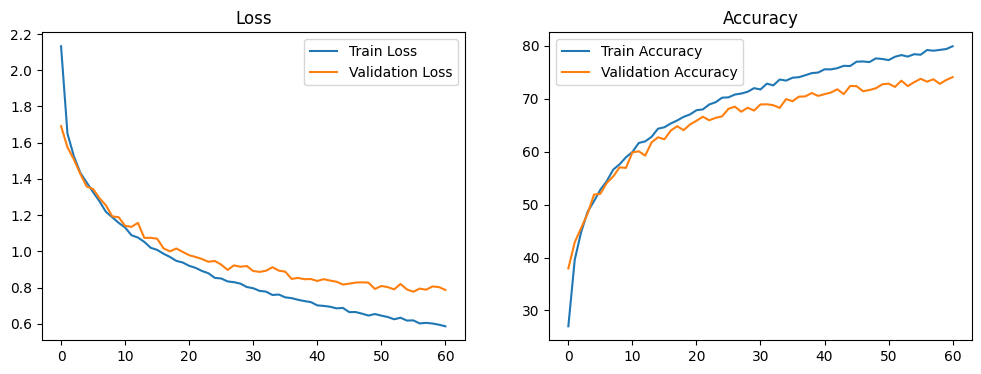

Combination 2 (MLP + KAN + MLP)
KANVGG16(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), 

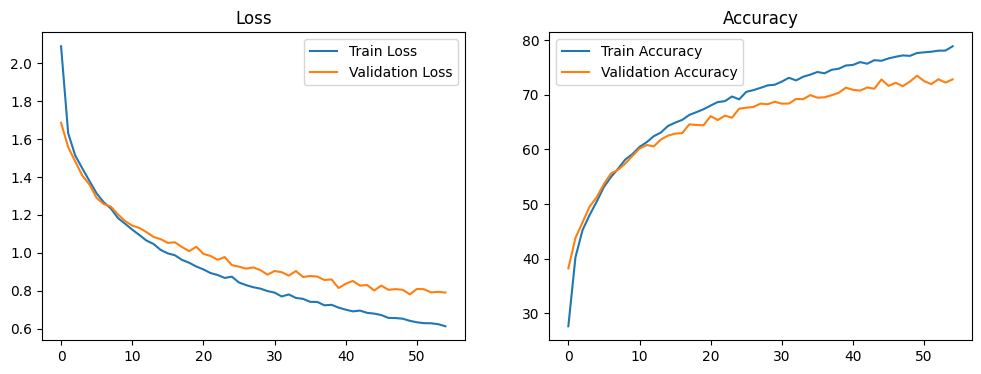

Combination 3 (MLP + MLP + KAN)
KANVGG16(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), 

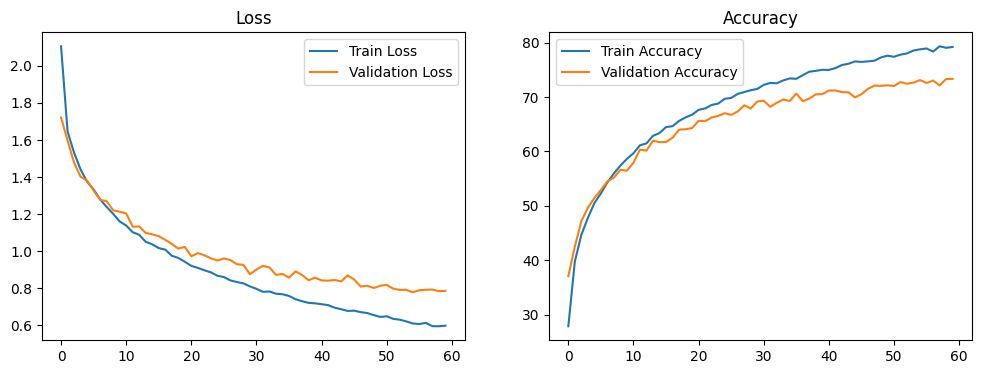

Combination 4 (KAN + KAN + MLP)
KANVGG16(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), 

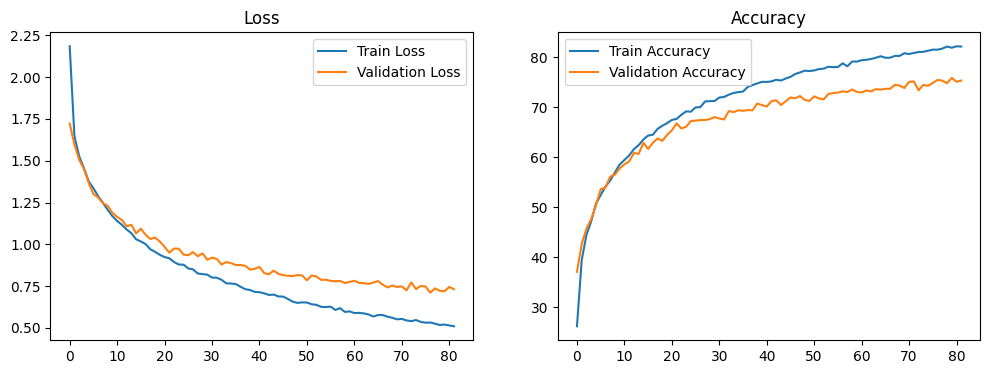

Combination 5 (KAN + MLP + KAN)
KANVGG16(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), 

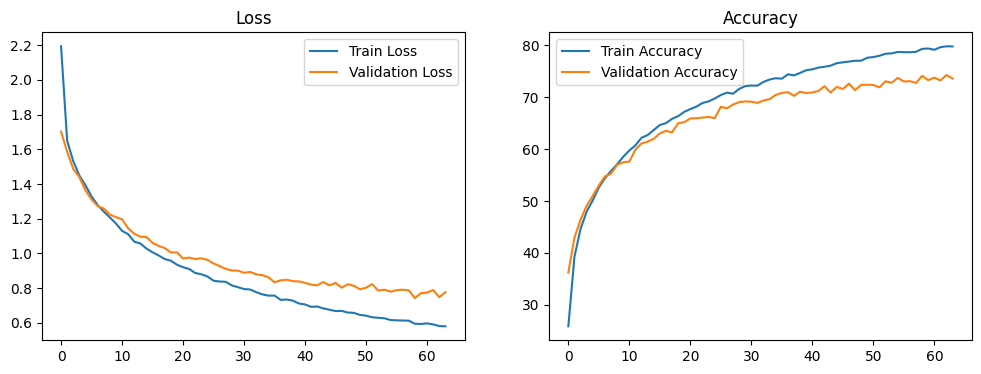

Combination 6 (MLP + KAN + KAN)
KANVGG16(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), 

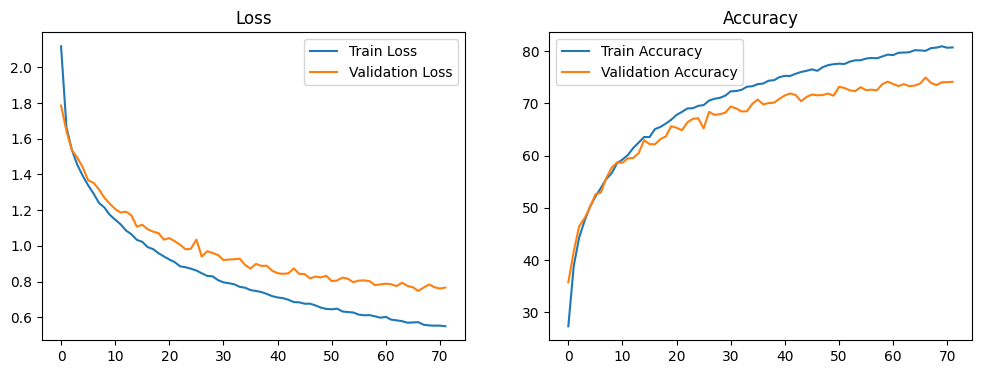

Combination 7 (MLP + MLP + MLP)
KANVGG16(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), 

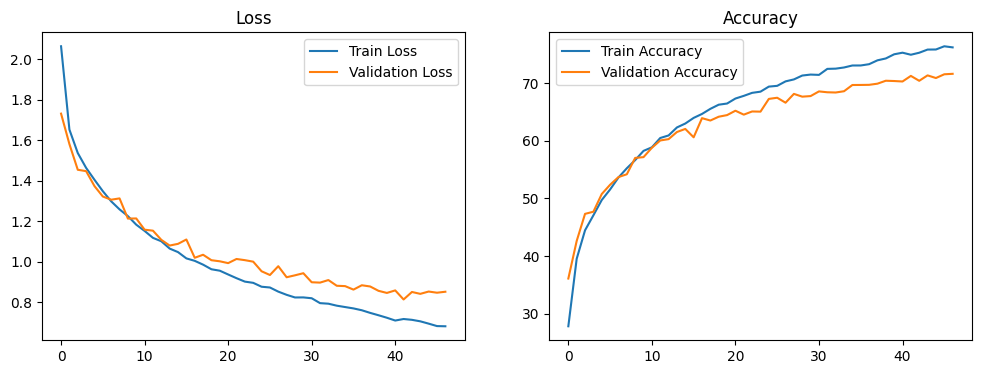

Combination 8 (KAN + KAN + KAN)
KANVGG16(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), 

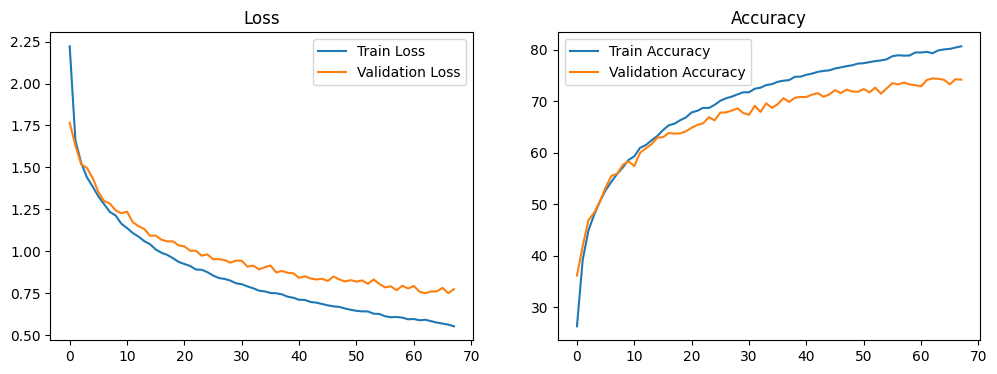

               Combination  Train Loss  Val Loss  Train Accuracy  \
0  Comb1 (KAN + MLP + MLP)    0.586682  0.787144         79.8825   
1  Comb2 (MLP + KAN + MLP)    0.613295  0.790765         78.8650   
2  Comb3 (MLP + MLP + KAN)    0.599082  0.786527         79.1950   
3  Comb4 (KAN + KAN + MLP)    0.509338  0.730900         82.1775   
4  Comb5 (KAN + MLP + KAN)    0.580087  0.776367         79.7625   
5  Comb6 (MLP + KAN + KAN)    0.549303  0.766150         80.7300   
6  Comb7 (MLP + MLP + MLP)    0.679730  0.850631         76.1975   
7  Comb8 (KAN + KAN + KAN)    0.552895  0.774210         80.6425   

   Val Accuracy  Test Accuracy  
0         74.06          81.08  
1         72.81          80.93  
2         73.34          80.68  
3         75.36          82.75  
4         73.57          81.77  
5         74.14          82.16  
6         71.61          79.77  
7         74.16          80.68  

Best result:
Combination       Comb4 (KAN + KAN + MLP)
Train Loss                       0

In [4]:
# Hyperparameters
epochs = 200
batch_size = 256

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Use DataParallel if using more than one GPU
if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model)

# Define transformations for training and validation data
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(32),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_val = transforms.Compose([
    transforms.Resize(32),
    transforms.CenterCrop(32),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load CIFAR-100 dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_val)

# Split training set into train and validation sets
train_indices, val_indices = train_test_split(list(range(len(trainset))), test_size=0.2, stratify=trainset.targets)
train_sampler = torch.utils.data.SubsetRandomSampler(train_indices)
val_sampler = torch.utils.data.SubsetRandomSampler(val_indices)

# Define DataLoaders
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, sampler=train_sampler, num_workers=2)
val_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, sampler=val_sampler, num_workers=2)
test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

# Loss function
criterion = nn.CrossEntropyLoss()

# Training and evaluation function
def train_and_evaluate(model, train_loader, val_loader, test_loader, criterion, optimizer, scheduler, device, num_epochs=epochs):
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    best_val_loss = float('inf')
    patience = 5
    patience_counter = 0

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for batch_idx, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            if batch_idx % 10 == 0:
                print(f'Train Epoch: {epoch} [{batch_idx * len(inputs)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')
                torch.cuda.empty_cache()

        train_loss = running_loss / len(train_loader)
        train_accuracy = 100 * correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for batch_idx, (inputs, labels) in enumerate(val_loader):
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

                if batch_idx % 10 == 0:
                    print(f'Val Epoch: {epoch} [{batch_idx * len(inputs)}/{len(val_loader.dataset)} ({100. * batch_idx / len(val_loader):.0f}%)]\tLoss: {loss.item():.6f}')
                    torch.cuda.empty_cache()

        val_loss /= len(val_loader)
        val_accuracy = 100 * correct / total
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.6f}, Train Accuracy: {train_accuracy:.2f}%, Validation Loss: {val_loss:.6f}, Validation Accuracy: {val_accuracy:.2f}%')

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), 'best_model.pth')
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping")
                break

        scheduler.step()

    # Load the best model and evaluate on the test set
    model.load_state_dict(torch.load('best_model.pth'))
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch_idx, (inputs, labels) in enumerate(test_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            # Store predictions and labels
            all_preds.extend(outputs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            if batch_idx % 10 == 0:
                print(f'Test Batch: [{batch_idx * len(inputs)}/{len(test_loader.dataset)} ({100. * batch_idx / len(test_loader):.0f}%)]')

    test_accuracy = 100 * correct / total
    
    # Save predictions and labels for ROC plotting
    np.save('preds_cifar10.npy', all_preds)
    np.save('true_labels_cifar10.npy', all_labels)
    
    # Plotting training and validation loss and accuracy
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.legend()
    plt.title('Loss')
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.legend()
    plt.title('Accuracy')
    plt.show()
    
    return train_losses, val_losses, train_accuracies, val_accuracies, test_accuracy

# Dictionary to store results
results = {
    'Combination': [],
    'Train Loss': [],
    'Val Loss': [],
    'Train Accuracy': [],
    'Val Accuracy': [],
    'Test Accuracy': []
}

combinations = [
    "KAN + MLP + MLP",
    "MLP + KAN + MLP",
    "MLP + MLP + KAN",
    "KAN + KAN + MLP",
    "KAN + MLP + KAN",
    "MLP + KAN + KAN",
    "MLP + MLP + MLP",
    "KAN + KAN + KAN"
]

# Iterate over all combinations
for idx, combination in enumerate(combinations, start=1):
    # print(f"List {idx} = Kombinasi {idx} ({combination})")
    print(f"Combination {idx} ({combination})")
    
    model = create_kanvgg16_classifier_combination(idx, num_classes=10).to(device)
    
    print(model)
    summary(model, input_size=(3, 32, 32))

    # Print model parameter details
    def print_parameter_details(model):
        for name, param in model.named_parameters():
            print(f"{name}: {param.size()} {'requires_grad' if param.requires_grad else 'frozen'}")

    print_parameter_details(model)
    
    optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.001, steps_per_epoch=len(train_loader), epochs=epochs)
    
    train_losses, val_losses, train_accuracies, val_accuracies, test_accuracy = train_and_evaluate(
        model, train_loader, val_loader, test_loader, criterion, optimizer, scheduler, device, num_epochs=epochs
    )
    
    results['Combination'].append(f'Comb{idx} ({combination})')
    results['Train Loss'].append(train_losses[-1])
    results['Val Loss'].append(val_losses[-1])
    results['Train Accuracy'].append(train_accuracies[-1])
    results['Val Accuracy'].append(val_accuracies[-1])
    results['Test Accuracy'].append(test_accuracy)

# Create DataFrame and display results
results_df = pd.DataFrame(results)
print(results_df)

# Menampilkan hasil terbaik berdasarkan kolom 'Test Accuracy'
best_result = results_df.loc[results_df['Test Accuracy'].idxmax()]
print("\nBest result:")
print(best_result)

# Optional: Save results to a CSV file
results_df.to_csv('kanvgg16_combinations_results.csv', index=False)

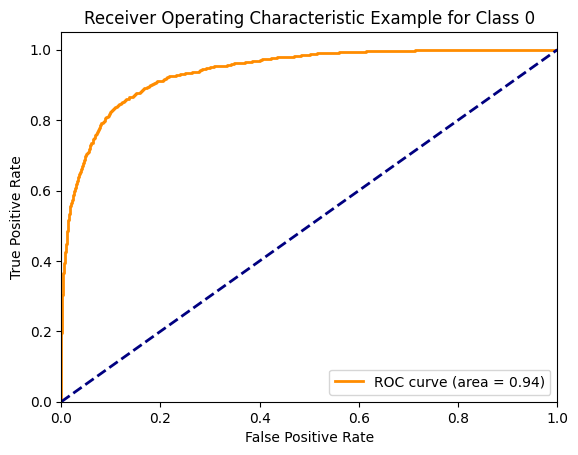

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Load predictions and true labels
all_preds = np.load('preds_cifar10.npy')
all_labels = np.load('true_labels_cifar10.npy')

# Binarize the labels for ROC computation
all_labels = label_binarize(all_labels, classes=range(10))

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(10):
    fpr[i], tpr[i], _ = roc_curve(all_labels[:, i], all_preds[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for the first class as an example
plt.figure()
plt.plot(fpr[0], tpr[0], color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc[0]:0.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Example for Class 0')
plt.legend(loc="lower right")
plt.show()
